# Plot qPCR of RNA export by EPN24-MCP with harvest at 48h and 72h

# Introduction

## Imports

In [1]:
import sys
import os
import time

import numpy as np
import scipy
import pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns

## Set output parameters

In [2]:
# Set pandas display options
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

# Set plot display options
FONTSIZE = 8  # universal fontsize
params = {
    'font.size': FONTSIZE,
    'axes.titlesize': FONTSIZE,
    'axes.labelsize': FONTSIZE,
    'legend.fontsize': FONTSIZE,
    'xtick.labelsize': FONTSIZE,
    'ytick.labelsize': FONTSIZE,
    'font.family': "Helvetica",
    'mathtext.fontset': 'custom',
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'figure.dpi': 300
   }
mpl.rcParams.update(params)
sns.set_style("ticks", {'axes.grid' : False})

# Set plot output options
output_dir = "outs/qPCR_export_rate_EPN24MCP"
output_suffix = ""
output_formats = [".png", ".pdf"]

mpl.rc('savefig', dpi=300)

# Define convenience function for saving figures

savefig = True
savefig_args = {"dpi": 300, "bbox_inches": "tight", "pad_inches": 0.1}

def save_figure(fig, name, output_dir=output_dir, output_suffix=output_suffix, output_formats=output_formats, savefig_args=savefig_args):
    if savefig:
        for output_format in output_formats:
            fig.savefig(output_dir + "/" + name + output_suffix + output_format, **savefig_args)
    return None

In [3]:
# Report plot parameters
sns.plotting_context()

{'font.size': 8.0,
 'axes.labelsize': 8.0,
 'axes.titlesize': 8.0,
 'xtick.labelsize': 8.0,
 'ytick.labelsize': 8.0,
 'legend.fontsize': 8.0,
 'legend.title_fontsize': None,
 'axes.linewidth': 0.8,
 'grid.linewidth': 0.8,
 'lines.linewidth': 1.5,
 'lines.markersize': 6.0,
 'patch.linewidth': 1.0,
 'xtick.major.width': 0.8,
 'ytick.major.width': 0.8,
 'xtick.minor.width': 0.6,
 'ytick.minor.width': 0.6,
 'xtick.major.size': 3.5,
 'ytick.major.size': 3.5,
 'xtick.minor.size': 2.0,
 'ytick.minor.size': 2.0}

# Load data

## Load qPCR data

In [4]:
infile = "../preprocessed_data/qPCR_data/qPCR_export_rate_EPN24MCP_Cq.csv"

cq_raw = pd.read_csv(infile, header=0)

print(cq_raw.shape)
cq_raw.head()

(18, 16)


,Sample,Condition,Harvest time (h),Replicate,Cq,Cq Mean,Cq Std. Dev,Starting Quantity (SQ),SQ Mean,SQ Std. Dev,LOD,SQ censored,Scale factor,RNA molecules,RNA molecules censored,RNA molecules LOD
0,95C-1,Gag-MCP,48,1,21.40085,21.34241,0.05795,32298.66675,33606.84367,1305.25710,31.88781,32298.66675,0.00001,2.976251e+09,2.976251e+09,2.938391e+06
1,95C-1,Gag-MCP,48,2,21.28497,21.34241,0.05795,34909.16123,33606.84367,1305.25710,31.88781,34909.16123,0.00001,3.216802e+09,3.216802e+09,2.938391e+06
2,95C-1,Gag-MCP,48,3,21.34140,21.34241,0.05795,33612.70302,33606.84367,1305.25710,31.88781,33612.70302,0.00001,3.097336e+09,3.097336e+09,2.938391e+06
3,95C-6,EPN24-MCP,48,1,20.27116,20.28262,0.40108,68906.46103,70031.69046,18566.01813,31.88781,68906.46103,0.00001,6.349578e+09,6.349578e+09,2.938391e+06
4,95C-6,EPN24-MCP,48,2,19.88740,20.28262,0.40108,89134.73191,70031.69046,18566.01813,31.88781,89134.73191,0.00001,8.213568e+09,8.213568e+09,2.938391e+06


# Preprocess data

## Summarize replicates

In [5]:
groups = cq_raw.groupby(["Sample"])  # group samples by origin

summary = pd.DataFrame()

summary["mean SQ"] = groups["Starting Quantity (SQ)"].mean()  # Calculate mean over replicates
summary["std SQ"] = groups["Starting Quantity (SQ)"].std()  # Calculate mean over replicates

summary["RNA molecules"] = groups["RNA molecules"].mean()
summary["RNA molecules STD"] = groups["RNA molecules"].std()

summary["RNA molecules censored"] = groups["RNA molecules censored"].mean()
summary["RNA molecules censored STD"] = groups["RNA molecules censored"].std()

summary["RNA molecules LOD"] = groups["RNA molecules LOD"].mean()

summary

,mean SQ,std SQ,RNA molecules,RNA molecules STD,RNA molecules censored,RNA molecules censored STD,RNA molecules LOD
Sample,,,,,,,
95C-1,33606.843667,1305.257104,3.096796e+09,1.202766e+08,3.096796e+09,1.202766e+08,2.938391e+06
95C-11,77.704080,41.305558,7.160259e+06,3.806216e+06,7.160259e+06,3.806216e+06,2.938391e+06
95C-6,70031.690463,18566.018132,6.453265e+09,1.710817e+09,6.453265e+09,1.710817e+09,2.938391e+06
Well3,6818.729010,327.742291,3.141654e+09,1.510036e+08,3.141654e+09,1.510036e+08,1.659378e+07
Well7,11421.545533,946.007533,5.262351e+09,4.358625e+08,5.262351e+09,4.358625e+08,1.659378e+07
Well9,8.269033,0.538132,3.809865e+06,2.479388e+05,1.659378e+07,0.000000e+00,1.659378e+07


# Visualize RNA accumulated at 48h and 72h (in separate experiments)

In [6]:
# Choose samples
index_ordered = ["95C-1", "95C-6", "95C-11", "Well3", "Well7", "Well9"]

In [7]:
# Get data of summary across replicates of selected wells
summary_subset = summary.loc[index_ordered]

print(summary_subset.shape)
summary_subset

(6, 7)


,mean SQ,std SQ,RNA molecules,RNA molecules STD,RNA molecules censored,RNA molecules censored STD,RNA molecules LOD
Sample,,,,,,,
95C-1,33606.843667,1305.257104,3.096796e+09,1.202766e+08,3.096796e+09,1.202766e+08,2.938391e+06
95C-6,70031.690463,18566.018132,6.453265e+09,1.710817e+09,6.453265e+09,1.710817e+09,2.938391e+06
95C-11,77.704080,41.305558,7.160259e+06,3.806216e+06,7.160259e+06,3.806216e+06,2.938391e+06
Well3,6818.729010,327.742291,3.141654e+09,1.510036e+08,3.141654e+09,1.510036e+08,1.659378e+07
Well7,11421.545533,946.007533,5.262351e+09,4.358625e+08,5.262351e+09,4.358625e+08,1.659378e+07
Well9,8.269033,0.538132,3.809865e+06,2.479388e+05,1.659378e+07,0.000000e+00,1.659378e+07


In [8]:
# Get data of replicates of selected wells
selector = cq_raw["Sample"].isin(index_ordered)
data = cq_raw.loc[selector]

print(data.shape)
data.head()

(18, 16)


,Sample,Condition,Harvest time (h),Replicate,Cq,Cq Mean,Cq Std. Dev,Starting Quantity (SQ),SQ Mean,SQ Std. Dev,LOD,SQ censored,Scale factor,RNA molecules,RNA molecules censored,RNA molecules LOD
0,95C-1,Gag-MCP,48,1,21.40085,21.34241,0.05795,32298.66675,33606.84367,1305.25710,31.88781,32298.66675,0.00001,2.976251e+09,2.976251e+09,2.938391e+06
1,95C-1,Gag-MCP,48,2,21.28497,21.34241,0.05795,34909.16123,33606.84367,1305.25710,31.88781,34909.16123,0.00001,3.216802e+09,3.216802e+09,2.938391e+06
2,95C-1,Gag-MCP,48,3,21.34140,21.34241,0.05795,33612.70302,33606.84367,1305.25710,31.88781,33612.70302,0.00001,3.097336e+09,3.097336e+09,2.938391e+06
3,95C-6,EPN24-MCP,48,1,20.27116,20.28262,0.40108,68906.46103,70031.69046,18566.01813,31.88781,68906.46103,0.00001,6.349578e+09,6.349578e+09,2.938391e+06
4,95C-6,EPN24-MCP,48,2,19.88740,20.28262,0.40108,89134.73191,70031.69046,18566.01813,31.88781,89134.73191,0.00001,8.213568e+09,8.213568e+09,2.938391e+06


findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


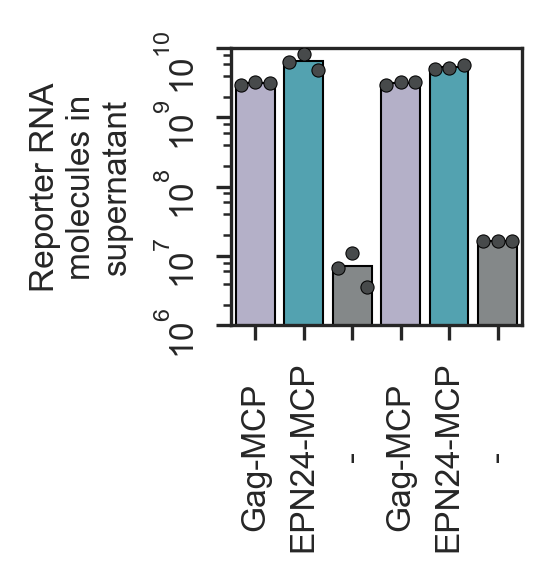

In [9]:
# Make simple bar plot, horizontal

field = "RNA molecules censored"

palette = ["#b1accc", "#44adbf", "#83888a"]  # set color of bars

fig, ax = plt.subplots(1, 1, figsize=(1.25, 1.2))

# Set axis scaling - must be done first so swarm plot dots do not overlap
ax.set_yscale("log")
ax.set_ylim(1e6, 1e10)

# Plot summary

y = summary_subset[field]
x = np.arange(len(y))

sns.barplot(ax=ax, x=x, y=y, palette=palette, lw=0.5, edgecolor="#010101")

# Plot individual points as swarm (sort columns appropriately)
sample_to_rank = dict(zip(index_ordered, range(len(index_ordered))))
data["rank"] = [sample_to_rank[s] for s in data["Sample"]]
data = data.sort_values(by="rank")

y_swarm = data[field]
x_swarm = np.array([x[rank] for rank in data["rank"]])

x_offset = np.array([-0.3, 0, 0.3])  # jitter offsets to avoid operlaps
x_swarm_offset = x_swarm + np.tile(x_offset, int(len(x_swarm)/len(x_offset)))

# Color by replicate well
ax.scatter(x_swarm_offset, y_swarm, color="#474a4b", edgecolor="#010101", linewidths=0.25, s=10, zorder=10)

ax.set_xlim(min(x)-0.5, max(x)+0.5)

ax.set_xlabel("")
ax.set_ylabel("Reporter RNA\nmolecules in\nsupernatant", labelpad=6)

ax.set_xticks([0, 1, 2, 3, 4, 5])
xticklabels = ["Gag-MCP", "EPN24-MCP", "-",
               "Gag-MCP", "EPN24-MCP", "-"]
ax.set_xticklabels(xticklabels, rotation=90, ha="center", va="center")
ax.tick_params(axis='x', which='major', pad=28)

ax.tick_params(axis='y', which='major', rotation=90)

locmaj = mpl.ticker.LogLocator(base=10,numticks=12) 
ax.yaxis.set_major_locator(locmaj)

locmin = mpl.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=12)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())

# ax.axhline(LOD, ls="--", color="k", lw=1)

# sns.despine()

save_figure(fig, "barplot_export_48h_72h")